## Ejemplos de inversión Geofísica

En este notebook veremos un ejemplo de inversión geofísica
la "tomografía acustica". Este ejemplo nos servirá para 
explorar los conceptos de problema indeterminado y algunas 
de las estrategias que pueden usarse para solucionar la 
inderterminación del problema.

In [4]:
# Importamos las librerias que vamos a usar
import numpy as np
import matplotlib.pyplot as plt

## Tomografía acustica 2D

El tiempo de viaje de las ondas acústicas (flechas en la figura) a través de las filas y columnas de una matriz cuadrada de ladrillos se mide con la fuente acústica "S" y el receptor "R" ubicados en los bordes del cuadrado. El problema inverso consiste en inferir las propiedades acústicas de los ladrillos, representadas aquí por los colores. Aunque el patrón general es variable espacialmente, se asume que los ladrillos individuales son homogéneos en su interior.

<img src="images/tomo_acustica.png">

Ejemplo 3: La tomografía acustica.

Asumiremos que todos los ladrillos tienen el mismo ancho y largo con la medida h = 1.

In [29]:
# largo y ancho de los ladrillos
h = 1

# Caso de tomografía acustica
N = 8    # número de observaciones
M = 16   # número de parámetros del modelo

# Construimos la matriz G
G = np.zeros((N,M), dtype=float)

# formamos la matriz kernel
for i in range(4):
    for j in range(4):
        # medidas en las lineas
            k = (i)*4 + j
            G[i][k] = h
            # medidas en las columnas
            k = (j)*4 + i
            G[i+4][k] = h
print(G)

[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]]


In [30]:
# Demos valores de velocidad de onda acustica a cada ladrillo
m = np.asarray([1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 5, 5, 5, 5])
# Calculemos la "lentitud" = 1 / velocidad
m = 1 / m
# Vector transpuesto para hacer   d = G m
# recuerden que G es 8x16 y m es 16x1 parámetros, d es 8x1 observaciones
m = m.T

# Medidas reales sin ruido
d = np.matmul(G, m)
print('Tiempos de viaje sin ruido:\n', d)
# Datos con ruido
d_con_ruido = np.zeros(len(d), dtype=float)

# Agregaremos ruido para crear medidas más reales
for i in range(len(d)):
    d_con_ruido[i] = d[i] + np.random.normal(0,0.01)  # 0.01 segundo max desviación
print('Tiempos de viaje con ruido:\n', d_con_ruido)


Tiempos de viaje sin ruido:
 [4.  3.  2.  0.8 2.2 2.2 2.7 2.7]
Tiempos de viaje con ruido:
 [4.00902202 3.00952379 1.99211481 0.80450165 2.20329441 2.18918245
 2.70859345 2.70013678]


## Solución del problema por mínimos cuadrados

Recordemos que el sistema
d = Gm
se puede solucionar con los siguiente pasos

G' d = G'G m

(G'G)^-1 G' d = (G'G)^-1 (G'G) m

(G'G)^-1 G' d = m_est

Entonces calculemos lo necesario para resolver este problema

### Ejemplo con solo dos ladrillos y 3 fuentes-receptores

In [10]:
#Construyamos G
#longitud de ladrillos
h = 1
G = np.array([[h, h],[h, 0], [0, h]])
d = np.array([[1.5],[1.0],[0.5]])

#Resolvemos el problema inverso
GT = G.T
GTG = np.matmul(GT, G)
GTGI = np.linalg.inv(GTG)
GTd = np.matmul(GT, d)
m_est = np.matmul(GTGI, GTd)
print(m_est,'\n', 1/m_est)

[[1. ]
 [0.5]] 
 [[1.]
 [2.]]


### La varianza de los parametros estimados

Los datos invariablemente contienen ruido que provoca errores en las estimaciones de los parámetros del modelo. Podemos calcular cómo este error de medición se traduce en errores en la estimación de "$m$" observando que todas las fórmulas derivadas anteriormente para las estimaciones de los parámetros del modelo son funciones lineales de los datos, en la forma $m^{est} = Md + v$, donde $M$ es alguna matriz y $v$ algún vector. Por lo tanto, si asumimos que los datos tienen una distribución caracterizada por alguna matriz de covarianza cov$[d]$, las estimaciones de los parámetros del modelo tienen una distribución caracterizada por una matriz de covarianza $cov[m] = M[cov[d]]M^T$. La covarianza de la solución entonces puede calcularse de manera directa. Si los datos no están correlacionados y tienen igual varianza $\sigma^2_d$, entonces se obtienen fórmulas muy simples para la covarianza de algunas de las soluciones más simples de problemas inversos.

La solución de mínimos cuadrados simple $m^{est} = [G^T G]^{-1} G^T d$ tiene una covarianza:

$$
[cov(m)]= \left[ [ G^T G]^{-1}G^T\right]\sigma^2_d I \left[ [ G^T G]^{-1}G^T\right]^T =  \sigma^2_d I [G^TG]^{-1}
$$

Un tema importante es cómo obtener una estimación de la varianza de los datos $\sigma^2_d$ que se pueda usar en esta ecuación. Una posibilidad es basarla en el conocimiento sobre la precisión inherente del proceso de medición, en cuyo caso se denomina una varianza previa. Por ejemplo, si se están midiendo longitudes con una regla con divisiones de 1 mm, la estimación $\sigma_d = 1/2$ mm sería una aproximación razonable.

Otra posibilidad es basar la estimación en la distribución de tamaños de los errores de predicción "$e$" determinados al ajustar un modelo a los datos, en cuyo caso se denomina una varianza posterior ($\sigma$ a posteriori). Una estimación razonable entonces sería:
$$
\sigma^2_d = \frac{1}{N-M}\sum^N_{i=1} e^2_i
$$

In [19]:
# Para el caso con solo 3 ladrillos
# Supongamos que el CENSIS pica los tiempos de arribo con 
# un error de décimas de segundo
# sigma_d = 0.1 segundos
# entonces sigma^2_d = 0.01 segundos

#entonces la matriz de covarianza del modelo es:
I = np.eye(2)   # la identidad
sigma_d = 0.1   # segundos
sigma2_d = sigma_d**2.

s2I = sigma2_d*I
covm_est = np.matmul(s2I, GTGI)
print(covm_est)


[[ 0.00666667 -0.00333333]
 [-0.00333333  0.00666667]]


¿Qué significa esto?

¿Qué son los términos de esta matriz?

¿Cómo podrían aterrizar estos valores con respecto a los parámetros obtenidos?

In [20]:
# ruido de 0.1 s
d = np.array([[1.5], [1.0], [0.5]])  #tiempos sin ruido
d_con_ruido = np.array([[1.4], [1.1], [0.4]])  #tiempos con ruido

# para datos con ruido
GTd_con_ruido = np.matmul(GT, d_con_ruido)

# resolver el sistema
m_est = np.matmul(GTGI, GTd)
m_est_con_ruido = np.matmul(GTGI, GTd_con_ruido)

print(m_est)
print(m_est_con_ruido)

[[1. ]
 [0.5]]
[[1.06666667]
 [0.36666667]]


## Ejemplo con 8 fuentes-receptores

In [26]:
# Calculamos G^T G
GT = G.T
GTd = np.matmul(GT, d_con_ruido)
GTG = np.matmul(GT, G)
GTGinv = np.linalg.inv(GTG)
m_est = np.matmul(GTGinv, GTd)
m_est_no_amor = m_est
print('m_real    m_est')
for i in range(M):
    print(m[i], '     ', m_est[i])

print('\n')
print('Datos observados VS sintéticos \n')
d_pred = np.matmul(G, m_est)
print('d_obs                   d_pred')
for i in range(N):
    print(d_con_ruido[i], '     ', d_pred[i])


m_real    m_est
1.0       64.0
1.0       -18.0
1.0       -23.0
1.0       -1.0
0.5       -76.0
0.5       -16.0
1.0       -7.0
1.0       56.0
0.5       -10.0
0.5       8.0
0.5       -3.0
0.5       -1.5
0.2       12.0
0.2       8.0
0.2       6.0
0.2       0.0


Datos observados VS sintéticos 

d_obs                   d_pred
4.007584941607261       22.0
3.0046383632113844       -43.0
2.0053646319301572       -6.5
0.8009065223163393       26.0
2.186774635642814       -10.0
2.2015288080681317       -18.0
2.6780031104534454       -27.0
2.697343264663481       53.5


¿Qué sucedió? 

¿Por qué no resolvimos el problema como en el caso anterior?

¿Alguna idea?

Problemas Indeterminados:

Cuando la ecuación $d = Gm$ no proporciona suficiente información para determinar de manera única todos los parámetros del modelo "$m$", se dice que el problema es indeterminado. Como vimos anteriormente, es decir los "$N$" datos son menos que las "$M$" incógnitas.

Por ejemplo, esto puede ocurrir si hay varias soluciones que tienen un error de predicción igual a cero. A partir del álgebra lineal elemental, sabemos que los problemas indeterminados ocurren cuando hay más incógnitas que datos, es decir, cuando M > N. 

En este caso $M = 16$ y $N = 8$. Por lo tanto $M > N$

Sin embargo, debemos tener en cuenta que no hay ninguna razón especial por la cual el error de predicción deba ser cero para un problema indeterminado. Frecuentemente, los datos determinan de manera única algunos de los parámetros del modelo pero no otros. Por ejemplo, consideremos el experimento acústico. Dado que no se realizan mediciones de la lentitud acústica en el quinto ladrillo dado el primer rayo, es evidente que este parámetro del modelo está completamente sin restricciones por los datos del primer rayo.

Si uno intentara resolver este problema con mínimos cuadrados, encontraría que el término $(G T G)^-1$ se indetermina ya que el núcleo de datos tiene una estructura muy deficiente. Aunque este es un caso bastante trivial en el que solo algunos de los parámetros del modelo son indeterminados, en experimentos realistas, el problema surge en formas más sutiles.

## Aproximación por mínimos cuadrados - problema de optimización

<img src="images/solucion_2.png">

Y la matriz de covarianza de los parámetros del modelo para este caso de mínimos cuadrados es:
$$
[cov(m)]= \left[ G^T[GG^T]^{-1} \right] \sigma^2_d I  \left[ G^T[GG^T]^{-1} \right]^T = \sigma^2_d G^T[GG^T]^{-2}G
$$

Hagamos la demostración paso a paso:

De la aplicación de los multiplicadores de lagrange y el proceso de optimización obtuvimos que:

$$
2m = G^T \lambda
$$
y sabemos que
$$
d = Gm
$$
entonces
$$
d = Gm = G(G^T\lambda/2)
$$

De aquí podemos darnos cuenta que la matríz $G^TG$ es cuadrada ($NXN$). Si esta matríz tiene una inversa, entonces podemos solucionar esta ecuación sabiendo que el multiplicador de lagrange es $\lambda=2(GG^T)^{-1}d$. Entonces sustituyendo esta expresión en la ecuación $2m=G^T\lambda$: 

$$
m^{est} = G^T[GG^T]^{-1}d
$$

Comprobemos si esta nueva aproximación soluciona el problema

In [33]:
GGT = np.matmul(G, GT)
GGTinv = np.linalg.inv(GGT)
m_est = np.matmul(np.matmul(GT, GGTinv), d_con_ruido)
m_est_optim = m_est
print('m_real    m_est')
for i in range(M):
    print(m[i], '     ', m_est[i])

print('\n')
print('Datos observados VS sintéticos \n')
d_pred = np.matmul(G, m_est)
print('d_obs                   d_pred')
for i in range(N):
    print(d_con_ruido[i], '     ', d_pred[i])

m_real    m_est
1.0       1.21556200917389
1.0       1.1488520403245206
1.0       1.0015681919210813
1.0       1.0011984199614428
0.5       0.9656874535727051
0.5       0.8989774847233358
1.0       0.7516936363198965
1.0       0.7513238643602582
0.5       0.7113352065114278
0.5       0.6446252376620585
0.5       0.4973413892586193
0.5       0.4969716172989808
0.2       0.4144319183636027
0.2       0.34772194951423335
0.2       0.2004381011107942
0.2       0.2000683291511557


Datos observados VS sintéticos 

d_obs                   d_pred
4.00902201641845       4.367180661380934
3.009523794013711       3.3676824389761957
1.9921148057686018       2.3502734507310867
0.8045016531773014       1.162660298139786
2.203294411000002       3.307016587621625
2.1891824517275285       3.0401767122241483
2.708593454591142       2.451041318610391
2.700136781445785       2.4495622307718374


## Aproximación - solución por partes

La mayoría de los problemas inversos que surgen en la práctica no son ni completamente sobredeterminados ni completamente indeterminados. Por ejemplo, en el problema de tomografía de rayos, pueden haber ladrillos por los cuales pasan varios rayos. La opacidad de rayos en algunos ladrillos está claramente sobredeterminada. Por otro lado, puede haber ladrillos que han sido completamente omitidos. Estos ladrillos son completamente indeterminados. También puede haber ladrillos que no pueden ser resueltas individualmente porque cada rayo que atraviesa uno también atraviesa la misma distancia del otro. Estos ladrillos también están indeterminados, ya que solo se determina su opacidad promedio.

<img src="images/solucion_dividida.png">

## Aproximación mínimos cuadrados amortiguados

<img src="images/solucion_amortiguada.png">

In [38]:
# Formamos la matriz de identidad
I = np.eye(M)

# epsilon
e = 0.01

# Calculamos G^T G
GT = G.T
GTd = np.matmul(GT, d_con_ruido)
GTG = np.matmul(GT, G)
e2I = e**2.*I
GTGe2I = GTG + e2I
GTGe2Iinv = np.linalg.inv(GTGe2I)
m_est = np.matmul(GTGe2Iinv, GTd)
m_est_amor = m_est
print('m_real    m_est')
for i in range(M):
    print(m[i], '     ', m_est[i])

print('\n')
print('Datos observados VS sintéticos \n')
d_pred = np.matmul(G, m_est)
print('d_obs                   d_pred')
for i in range(N):
    print(d_con_ruido[i], '     ', d_pred[i])


m_real    m_est
1.0       0.9400517253579892
1.0       0.936523823733296
1.0       1.066373328219015
1.0       1.0642592127796888
0.5       0.6901834164518732
0.5       0.6866555148430962
1.0       0.8165050193174466
1.0       0.8143909038940365
0.5       0.43583752805034237
0.5       0.43230962642837767
0.5       0.562159130908185
0.5       0.560045015462947
0.2       0.1389416623114812
0.2       0.1354137606722361
0.2       0.2652632651570457
0.2       0.26314914972499537


Datos observados VS sintéticos 

d_obs                   d_pred
4.00902201641845       4.007208090089989
3.009523794013711       3.0077348545064524
1.9921148057686018       1.9903513008498521
0.8045016531773014       0.8027678378657583
2.203294411000002       2.205014332171686
2.1891824517275285       2.190902725677006
2.708593454591142       2.7103007436016924
2.700136781445785       2.7018442818616677


In [55]:
# Minimos cuadrados pesados
# El peso se define por cada dato

W = np.zeros((N, N), dtype=float)
W[0][0] = 100.
W[1][1] = 0.
W[2][2] = 0.
W[3][3] = 0.
W[4][4] = 0.
W[5][5] = 0.
W[6][6] = 0.
W[7][7] = 100.
GTW = np.matmul(GT, W)
GTWG = np.matmul(GTW, G)
GTWGI = np.linalg.inv(GTWG + e2I)
GTWd = np.matmul(GTW, d_con_ruido)
m_est = np.matmul(GTWGI, GTWd)
m_est_pesado = m_est
print('m_real    m_est')
for i in range(M):
    print(m[i], '     ', m_est[i])

print('\n')
print('Datos observados VS sintéticos \n')
d_pred = np.matmul(G, m_est)
print('d_obs                   d_pred')
for i in range(N):
    print(d_con_ruido[i], '     ', d_pred[i])


m_real    m_est
1.0       0.8890632120892406
1.0       0.8890632120892406
1.0       0.8890632120892406
1.0       1.3418314915616065
0.5       0.0
0.5       0.0
1.0       0.0
1.0       0.452768279472366
0.5       0.0
0.5       0.0
0.5       0.0
0.5       0.45276827889028937
0.2       0.0
0.2       0.0
0.2       0.0
0.2       0.45276827923953533


Datos observados VS sintéticos 

d_obs                   d_pred
4.00902201641845       4.009021127829328
3.009523794013711       0.452768279472366
1.9921148057686018       0.45276827889028937
0.8045016531773014       0.45276827923953533
2.203294411000002       0.8890632120892406
2.1891824517275285       0.8890632120892406
2.708593454591142       0.8890632120892406
2.700136781445785       2.700136329163797


## Comparación de modelos resultantes

Es necesario tener herramientas para estimar que 
tan bueno ha sido un modelo en ajustar tanto los 
datos como los parámetros del modelo (si estos se conocen).

Estas herramientas deben ser objetivas y no depender
de la subjetividad del analista.

Algunas de las más famosas normas para estimar el 
ajuste a los datos y modelo son la norma L1 y la norma L2.

<img src="images/normas.png" width="70%">



/tmp/ipykernel_19819/3838932545.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  Model_est_0[i][j] = 1/m_est_no_amor[k]
/tmp/ipykernel_19819/3838932545.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


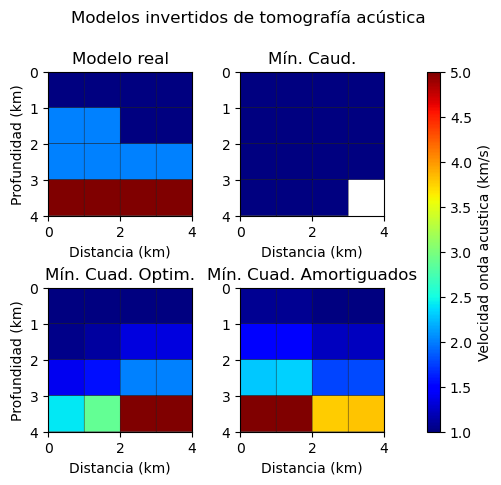

In [41]:
Model = np.zeros((4,4), dtype=float)
Model_est_0 = np.zeros((4,4), dtype=float)
Model_est_1 = np.zeros((4,4), dtype=float)
Model_est_2 = np.zeros((4,4), dtype=float)

k = 0
for i in range(4):
    for j in range(4):
        Model[i][j] = 1/m[k]
        Model_est_0[i][j] = 1/m_est_no_amor[k]
        Model_est_1[i][j] = 1/m_est_optim[k]
        Model_est_2[i][j] = 1/m_est_amor[k]
        k += 1

# Color map para ser utilizado
cmap = plt.cm.get_cmap('jet')

        
fig1 = plt.figure(1)
fig1.suptitle('Modelos invertidos de tomografía acústica')
ax1 = fig1.add_subplot(2, 2, 1)
ax1.set_position([0.15, 0.55, 0.3, 0.3])
s1 = ax1.pcolor(Model, clim=([1, 5]), edgecolor='black', cmap=cmap)
ax1.set_title('Modelo real')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_aspect('equal')
ax1.set_ylabel('Profundidad (km)')
ax1.set_xlabel('Distancia (km)')

ax2 = fig1.add_subplot(2, 2, 2)
ax2.set_position([0.45, 0.55, 0.3, 0.3])
s2 = ax2.pcolor(Model_est_0, clim=([1, 5]), edgecolor='black', cmap=cmap)
ax2.set_title('Mín. Caud.')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_aspect('equal')
ax2.set_xlabel('Distancia (km)')

ax3 = fig1.add_subplot(2, 2, 3)
ax3.set_position([0.15, 0.1, 0.3, 0.3])
s3 = ax3.pcolor(Model_est_1, clim=([1, 5]), edgecolor='black', cmap=cmap)
ax3.set_title('Mín. Cuad. Optim.')
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_aspect('equal')
ax3.set_xlabel('Distancia (km)')
ax3.set_ylabel('Profundidad (km)')

ax4 = fig1.add_subplot(2, 2, 4)
ax4.set_position([0.45, 0.1, 0.3, 0.3])
s4 = ax4.pcolor(Model_est_2, clim=([1, 5]), edgecolor='black', cmap=cmap)
ax4.set_title('Mín. Cuad. Amortiguados')
ax4.set_ylim(ax4.get_ylim()[::-1])
ax4.set_aspect('equal')
ax4.set_xlabel('Distancia (km)')

# Colorbar
cbaxes = fig1.add_axes([0.78, 0.1, 0.02, 0.75]) 
cb = fig1.colorbar(s1, ax=ax3, cax=cbaxes, orientation='vertical')
cb.set_label('Velocidad onda acustica (km/s)')
